In [1]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
#!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-uuutiw8_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-uuutiw8_
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=ff6df5605ccade9a51c829e88a66b44791f637c8d9ca46b7d20a9631131d90c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-9i8l6h7u/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
#from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

# Loading data

In [3]:
from datasets import load_dataset, Dataset
from PIL import Image
import io
from tqdm import tqdm

def load_and_process_dataset(dataset_name, split='train'):
    """
    Load a dataset from the Hugging Face Hub and convert Tiff images to Pillow images.

    Args:
        dataset_name (str): Name of the dataset on the Hugging Face Hub.
        split (str, optional): Split of the dataset to load (default is 'train').

    Returns:
        dataset (Dataset): Dataset object from dictionary containing the loaded dataset with list of Pillow images and corresponding binary masks.
    """
    # Load dataset
    dataset = load_dataset(dataset_name, split=split, streaming=False)

    # Initialize lists to store Pillow images and corresponding labels(masks)
    dataset_dict = {"image": [], "label": []}

    # Iterate over the dataset
    for data in tqdm(dataset):
        # Convert label Tiff bytes to Pillow image
        label_tif = Image.open(io.BytesIO(data['label_tif']))
        # label_tif = np.fromfile(data['label_tif'])

        if np.array(label_tif).max() != 0:
          # Convert Tiff image bytes to Pillow image
          # tif_image = Image.open(io.BytesIO(data['tif'])) # allow_pickle=True
          tif_image = Image.open(io.BytesIO(data['tif']))
          # np.frombuffer(k, dtype=i.dtype)

          # Append Pillow image and label to the lists
          dataset_dict["image"].append(tif_image)
          dataset_dict["label"].append(label_tif)

    # Create the dataset using the datasets.Dataset class
    dataset = Dataset.from_dict(dataset_dict)

    return dataset

In [ ]:
# Load dataset from hugging face
dataset = load_and_process_dataset("back2classroom/sidewalks")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/180000 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/19999 [00:00<?, ? examples/s]

100%|██████████| 180000/180000 [01:12<00:00, 2473.32it/s]


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 88863
})

Note: Only 88,863 image patches are considered with non-empty binary masks for training.

Below, we plot some sample images along with the ground truth binary masks loaded from Huggingface.

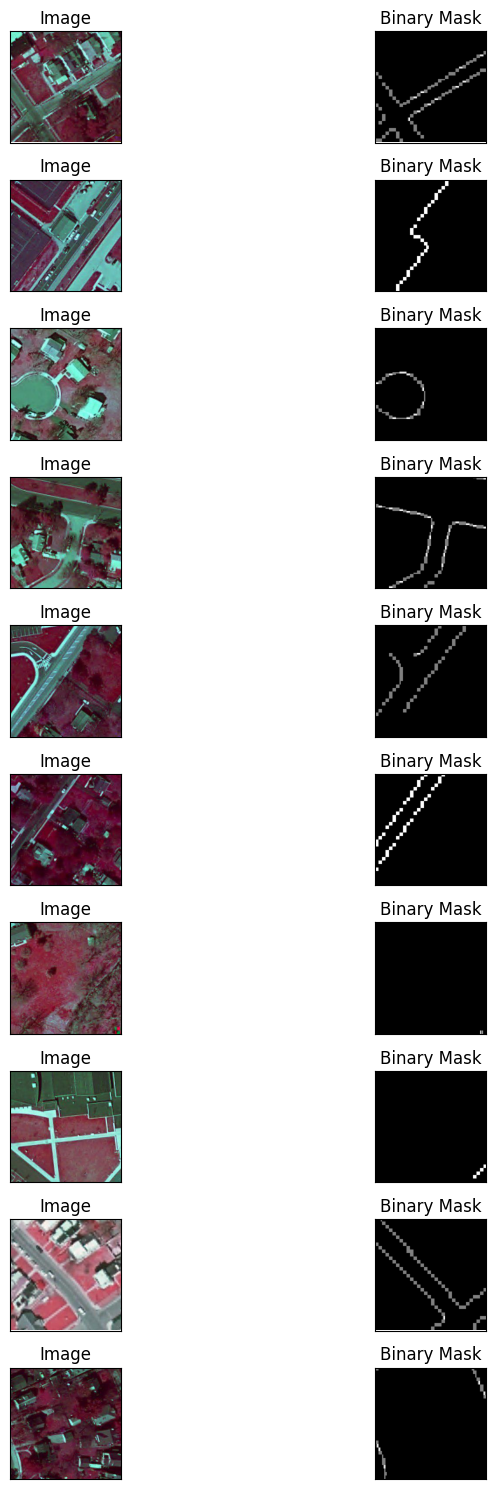

In [ ]:
def plot_images_with_masks(dataset, num_images=10):
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 15))

    for i, idx in enumerate(indices):
        example_image = dataset[idx]["image"]
        example_mask = dataset[idx]["label"]
        axes[i, 0].imshow(np.array(example_image), cmap='gray')
        axes[i, 0].set_title('Image')
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].set_xticklabels([])
        axes[i, 0].set_yticklabels([])

        axes[i, 1].imshow(example_mask, cmap='gray')
        axes[i, 1].set_title('Binary Mask')
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])
        axes[i, 1].set_xticklabels([])
        axes[i, 1].set_yticklabels([])

    plt.tight_layout()
    plt.show()

# Call the function to plot 10 random images with their masks
plot_images_with_masks(dataset, 10)

# Getting a Dataset Ready for Training

In [4]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
# Pin memory true since data is loaded in cpu and we need it in gpu
train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True, drop_last=False, pin_memory=True)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([12, 3, 1024, 1024])
original_sizes torch.Size([12, 2])
reshaped_input_sizes torch.Size([12, 2])
input_boxes torch.Size([12, 1, 4])
ground_truth_mask torch.Size([12, 256, 256])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([12, 256, 256])

# Loading Model

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def save_checkpoint(epoch, model, optimizer, loss, checkpoint_dir):
  checkpoint = {
    "epoch": epoch,
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "mean_loss": loss
  }

  torch.save(checkpoint, checkpoint_dir + f'checkpoint_at_epoch_{epoch}.pt')

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/AI_Project/checkpoints/"

In [ ]:
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    save_checkpoint(epoch, model, optimizer, mean(epoch_losses), checkpoint_dir)

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 7406/7406 [3:17:01<00:00,  1.60s/it]


EPOCH: 0
Mean loss: -59888.03435962367


 49%|████▉     | 3621/7406 [1:36:04<1:40:25,  1.59s/it]


KeyboardInterrupt: 

# Runtime disconnected halfway through epoch 2, so have to stop and restart epoch 2...

In [ ]:
# Epoch 1 checkpoint has been saved, so defining a function load_checkpoint
# to get the weights and optimizer from end of Epoch 1 to resume training.

# References:
# https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/4
# https://discuss.pytorch.org/t/saving-model-and-optimiser-and-scheduler/52030

def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    epoch = checkpoint["epoch"]
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    loss = checkpoint["mean_loss"]
    return epoch, loss, model, optimizer

In [ ]:
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
checkpoint_path = "/content/drive/MyDrive/AI_Project/checkpoints/checkpoint_at_epoch_0.pt"

# Load the checkpoint
epoch, loss, model, optimizer = load_checkpoint(checkpoint_path, model, optimizer)

In [ ]:
#Training loop
num_epochs = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
# Now individually transfer the optimizer parts to device...
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

model.train()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
def save_checkpoint(epoch, model, optimizer, loss, checkpoint_dir):
  checkpoint = {
    "epoch": epoch,
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "mean_loss": loss
  }

  torch.save(checkpoint, checkpoint_dir + f'checkpoint_at_epoch_{epoch}.pt')

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/AI_Project/checkpoints/"

In [ ]:
# Training epoch 2 again
for epoch in range(epoch, num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    save_checkpoint(epoch, model, optimizer, mean(epoch_losses), checkpoint_dir)

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 7406/7406 [3:19:08<00:00,  1.61s/it]


EPOCH: 0
Mean loss: -437283.2306718018


  1%|          | 38/7406 [01:01<3:20:21,  1.63s/it]


KeyboardInterrupt: 

Oops, the previous loop should have started at epoch **1** not 0, but we forgot to do epoch = epoch + 1 for display purposes previously , so the loop was continuing to the third epoch, which is stopped. Nonetheless, we now have our model trained for two epochs.

# Inference

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

We load the model weights after training for 2 epochs, to perform inference on 'val' split of sidewalks dataset.

In [7]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
sidewalk_model = SamModel(config=model_config)
# Update the model by loading the weights from saved file.
# Indexed from 0 so epoch_1 below is the second epoch
checkpoint = torch.load("/content/drive/MyDrive/SAM_sidewalk/checkpoints/checkpoint_at_epoch_1.pt")
sidewalk_model.load_state_dict(checkpoint["model"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

<All keys matched successfully>

In [8]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
sidewalk_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [9]:
# Load 'val' split of dataset from hugging face
val_dataset = load_and_process_dataset("back2classroom/sidewalks", split='val')


Generating train split:   0%|          | 0/180000 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/19999 [00:00<?, ? examples/s]

100%|██████████| 19999/19999 [00:07<00:00, 2533.15it/s]


In [10]:
val_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 10082
})

Note: Only 10,082 image patches are considered with non-empty binary masks.

**Observations:**

Now, we generate probability maps for 5 random images from the 'val' split of our custom dataset and compare it against the ground truth masks.

We test various thresholds for converting the probability masks to binary masks and threshold of 0.85 appeared to generate the best results.

We observe that with only 2 epochs of training, the model is able to generate reasonable masks for most images. However, there is a decent number of false positive predictions for pixels that do not belong to sidewalks. We believe, with enough training (for more # epochs), the model would get better but we currently stop training at 2 epochs owing to high computational complexity.

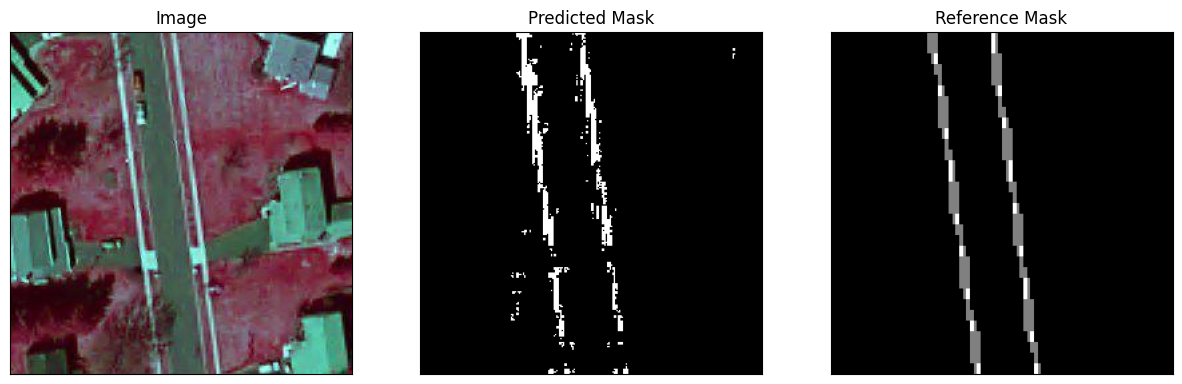

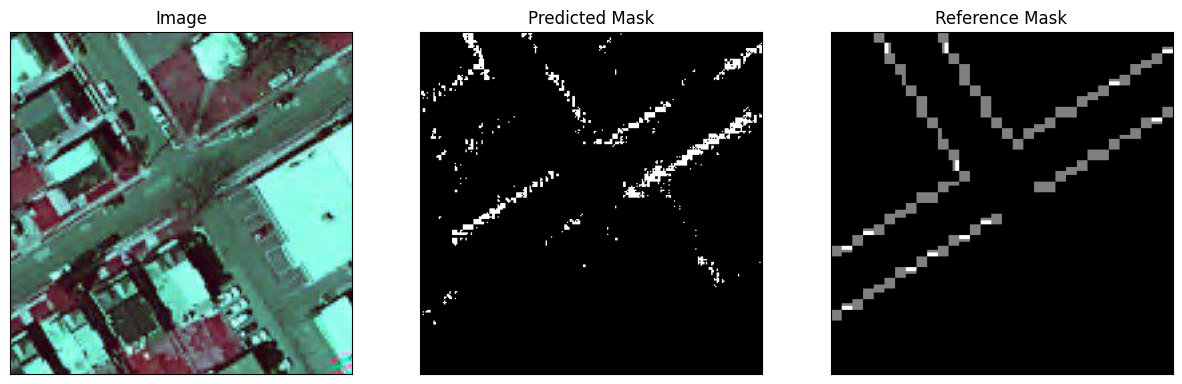

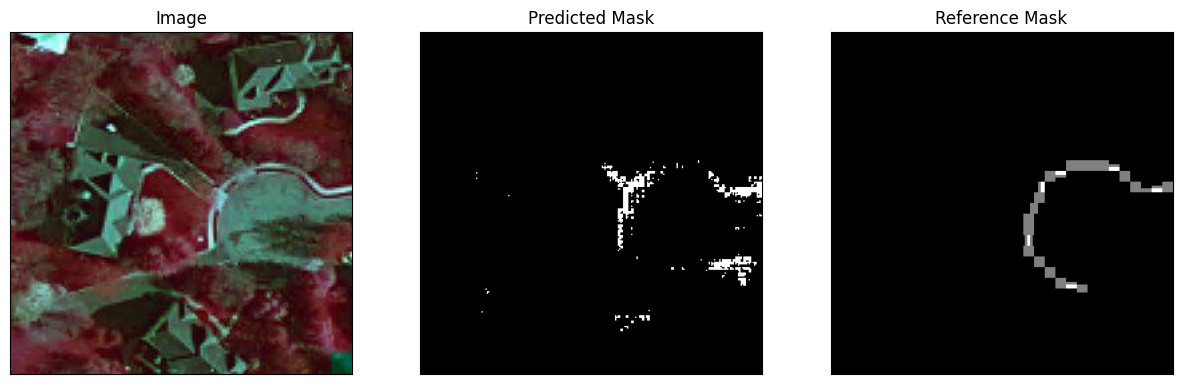

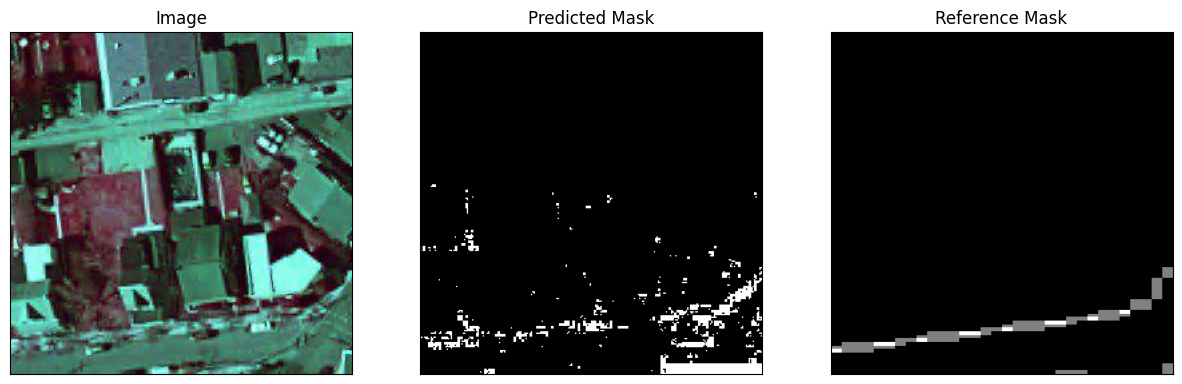

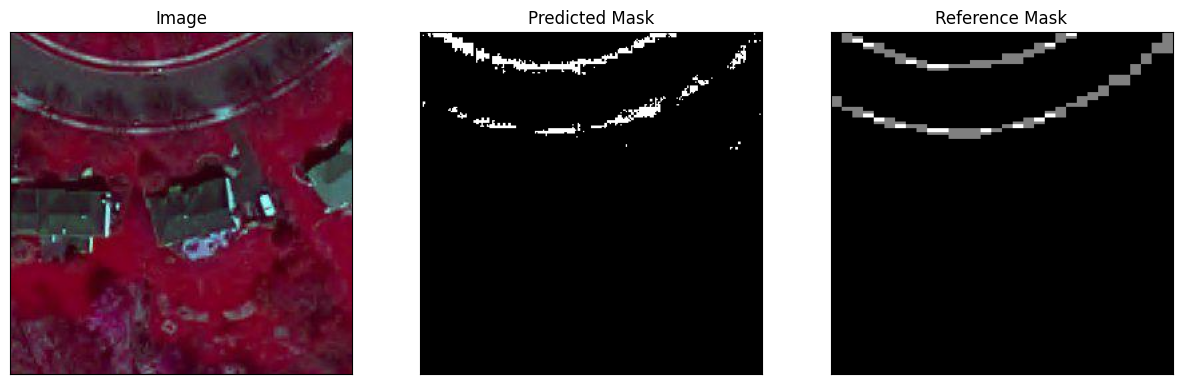

In [20]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# Predict sidewalks binary masks for 5 random samples from 'val' set
for i in range(5):
  # let's take a random sample from validation dataset
  idx = random.randint(0, 10082)

  # load image
  test_image = val_dataset[idx]["image"]

  # get box prompt based on ground truth segmentation map
  ground_truth_mask = np.array(val_dataset[idx]["label"])
  prompt = get_bounding_box(ground_truth_mask)

  # prepare image + box prompt for the model
  inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

  # Move the input tensor to the GPU if it's not already there
  inputs = {k: v.to(device) for k, v in inputs.items()}

  sidewalk_model.eval()

  # forward pass
  with torch.no_grad():
      outputs = sidewalk_model(**inputs, multimask_output=False)

  # apply sigmoid
  medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  # convert soft mask to hard mask
  medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
  medsam_seg = (medsam_seg_prob > 0.85).astype(np.uint8)


  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Plot the first image on the left
  axes[0].imshow(np.array(test_image))
  axes[0].set_title("Image")

  # Plot the second image on the right
  axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
  axes[1].set_title("Predicted Mask")

  # # Plot the second image on the right
  # axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
  # axes[2].set_title("Probability Map")

  # Plot the ground truth binary mask
  axes[2].imshow(np.array(val_dataset[idx]["label"]), cmap='gray')
  axes[2].set_title("Reference Mask") # ground truth binary mask

  # Hide axis ticks and labels
  for ax in axes:
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_xticklabels([])
      ax.set_yticklabels([])

  # Display the images side by side
  plt.show()
